### Mount Google Drive for file access

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Import cleaned dataset

In [3]:
import pandas as pd

# load and preview dataframe
df = pd.read_csv('/content/gdrive/My Drive/Python/Mtn_proj_model/data/df2_dummies.csv', dtype='str')
df.head(1)

,id,latitude,location,longitude,name,pitches,rating,starVotes,stars,type,scoreStars,length_ft,FA_data,page_views,views_per_month,desc,locInfo,pro,commentList,apPopularityScore,rating_new,grade,IRCRA_grade,sketch_factor,type_Aid,type_Alpine,type_Boulder,type_Ice,type_Mixed,type_Snow,type_Sport,type_TR,type_Trad
0,105906185,35.8734,"['Arkansas', ""Sam's Throne & Surroundings"", ""S...",-93.0472,Arkansas Roofs 101,1.0,5.10a,5.0,3.4,Trad,2.4,50.0,['Jon Von Canon 3/91'],577.0,4.0,Climb the fistcrack 20 feet to the base of the...,At the right end of the Too Big to Finger Wall...,"Pro to 3.5 or 4"". Rap off trees if there aren...",[],0.34006,['5.10a'],5.10a,10.0,PG,0,0,0,0,0,0,0,0,1


### Perform additional data cleaning


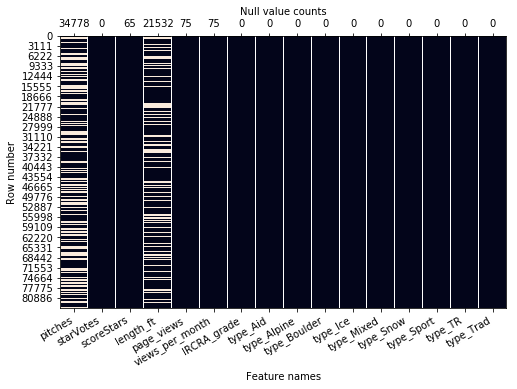

Total null values in dataframe: 56525


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# define function to visualize null values in dataframe

def visualize_nulls(dataframe):
  # visualize null values in columns
  fig, ax = plt.subplots(figsize=(8,5))
  sns.heatmap(dataframe.isnull(), cbar=False, ax=ax)

  # initialize second x-axis for null value counts
  ax2 = ax.twiny()
  ax2Ticks = ax.get_xticks()   
  ax2.set_xticks(ax2Ticks)
  ax2.set_xbound(ax.get_xbound())

  # show null value counts
  ax2.set_xticklabels(df_numerical.isnull().sum(axis=0))

  # format lower axis
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')

  # set axes labels
  ax.set_xlabel('Feature names')
  ax2.set_xlabel('Null value counts')
  ax.set_ylabel('Row number')

  # show plot and print total null values in dataframe
  plt.show()
  print('Total null values in dataframe: {}'.format(dataframe.isnull().sum().sum()))
  
# drop non-numerical data columns and store in new dataframe
df_numerical = df.drop(['id','latitude','longitude','location','name','rating','type','stars',
                        'FA_data','desc','locInfo','pro','commentList','apPopularityScore',
                        'rating_new','grade','sketch_factor'], axis=1).astype(float)

# show null values in df_numerical
visualize_nulls(df_numerical)

#### Fill or drop missing data

There are quite a few null values in columns 'pitches' and 'length_ft'. Due to the size of the dataframe, sparsely distributed null values in other columns are not visible in the figure. Because 'scoreStars' will be used as the data label, rows missing this value will be dropped.

In [0]:
# drop rows missing data label
df_numerical.dropna(subset=['scoreStars'], inplace=True)

Other columns missing data can be filled using mean, median, or mode values. In the case of 'pitches', most routes are one pitch, so that value will be used to fill in missing data.

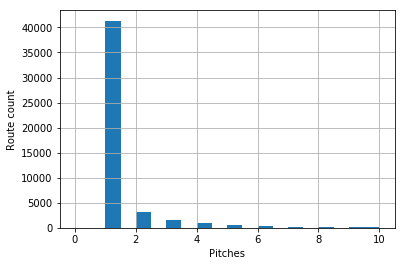

In [6]:
# plot histogram for pitch number
ax = df_numerical['pitches'].dropna().hist(bins=20, range=[0,10])
_ = ax.set_xlabel('Pitches')
_ = ax.set_ylabel('Route count')

# fill null values with most common entry
df_numerical['pitches'].fillna(1, inplace=True)

There are some outliers in route length which are probably incorrect values. For example, the maximum value is 90,000 ft, but the tallest mountain, Mt. Everest, is only 29,000 ft. For now missing values will be filled, and data will be clipped to remove extreme values.

In [7]:
# maximum route length in dataset
l_max = df_numerical['length_ft'].max()
print("The maximum entry for 'length_ft' is {0:.0f} ft.".format(l_max))

The maximum entry for 'length_ft' is 90110 ft.


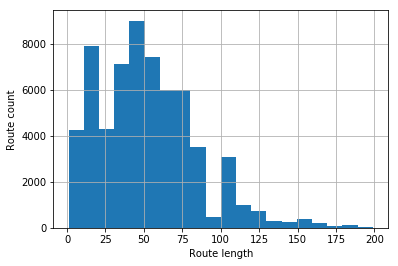

In [8]:
# plot histogram for 'length_ft', clipped to most common range of values
ax = df_numerical['length_ft'][df_numerical['length_ft'] < 200].dropna().hist(bins=20)
_ = ax.set_xlabel('Route length')
_ = ax.set_ylabel('Route count')

# get median value -- this is the same regardless of whether data is filtered as in the histogram
l_median = df_numerical['length_ft'].median()
df_numerical['length_ft'].fillna(l_median, inplace=True)

Similarly, fill missing values for 'page_views' and 'views_per_month' with median values.

In [0]:
df_numerical['page_views'].fillna(df_numerical['page_views'].median(), inplace=True)
df_numerical['views_per_month'].fillna(df_numerical['views_per_month'].median(), inplace=True)

Check once more to make sure that all missing values have been accounted for. Looks good now.

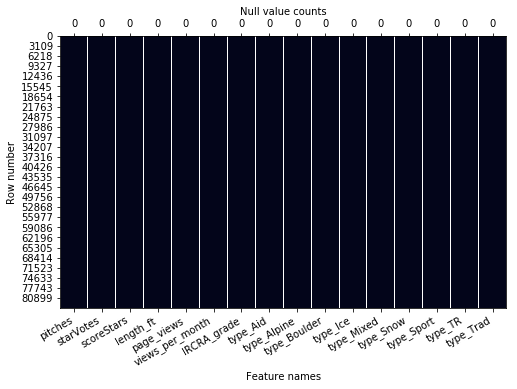

Total null values in dataframe: 0


In [10]:
visualize_nulls(df_numerical)

### Create deep learning model using numerical features

Use 'scoreStars' as labels and drop frame dataframe

In [0]:
y = df_numerical['scoreStars'].values
df_X = df_numerical.drop(['scoreStars'], axis=1)

Normalize data columns by min-max scaling and return features as array

In [0]:
# normalize non-dummy columns
cols_to_norm = ['pitches','starVotes','length_ft','page_views','views_per_month','IRCRA_grade']
df_X[cols_to_norm] = df_X[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
X = df_X.values

Split the data into model training and testing sets

In [0]:
from sklearn.model_selection import train_test_split

xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size = 0.2, random_state = 42)

Build the numeric feature model using Keras API

Using TensorFlow backend.
W0613 22:23:44.397907 140161033561984 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0613 22:23:44.436688 140161033561984 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0613 22:23:44.445673 140161033561984 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0613 22:23:44.470041 140161033561984 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0613 22:23:44.514692 14016

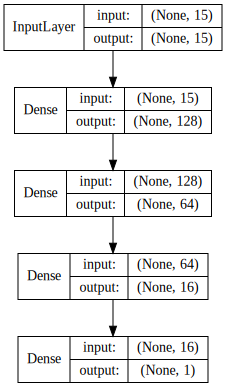

In [14]:
from keras import models
from keras import layers
from keras.callbacks import EarlyStopping
from keras.utils import plot_model, vis_utils
from IPython.display import SVG

# create regression model using keras API
inputs = layers.Input(shape=(X.shape[1],))
x = layers.Dense(128, kernel_initializer='normal', activation='relu')(inputs)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(16, activation='relu')(x)
predictions = layers.Dense(1, activation='linear')(x)

# build the above model
model = models.Model(inputs=inputs, outputs=predictions)

# compile the model
model.compile(optimizer='adam',
              loss='mse',
              metrics=['mae'])

# split the training data once more into training and validation data
x_partial_train, x_val, y_partial_train, y_val = train_test_split(xTrain, yTrain, test_size = 0.2, random_state = 42)

# define an early stopping callback (may not be necessary since training is fast and converges)
useEarlyStopping = False
if useEarlyStopping:
  callbacks = [EarlyStopping(monitor='val_loss', patience=50, min_delta=0.0001)]
else:
  callbacks=None

# visualize model
SVG(vis_utils.model_to_dot(model, show_shapes=True, show_layer_names=False).create(prog='dot', format='svg'))

Fit the model

In [15]:
# fit the model
history = model.fit(x_partial_train,
                    y_partial_train,
                    epochs=50,
                    verbose=1,
                    batch_size=128,
                    validation_data=(x_val, y_val),
                    callbacks=callbacks)

W0613 22:23:45.060789 140161033561984 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 53711 samples, validate on 13428 samples
Epoch 1/50
53711/53711 [==============================] - 1s 27us/step - loss: 0.8092 - mean_absolute_error: 0.6536 - val_loss: 0.3931 - val_mean_absolute_error: 0.4931
Epoch 2/50
53711/53711 [==============================] - 1s 14us/step - loss: 0.3930 - mean_absolute_error: 0.4891 - val_loss: 0.3832 - val_mean_absolute_error: 0.4864
Epoch 3/50
53711/53711 [==============================] - 1s 14us/step - loss: 0.3775 - mean_absolute_error: 0.4788 - val_loss: 0.3645 - val_mean_absolute_error: 0.4717
Epoch 4/50
53711/53711 [==============================] - 1s 15us/step - loss: 0.3654 - mean_absolute_error: 0.4703 - val_loss: 0.3586 - val_mean_absolute_error: 0.4678
Epoch 5/50
53711/53711 [==============================] - 1s 15us/step - loss: 0.3581 - mean_absolute_error: 0.4649 - val_loss: 0.3543 - val_mean_absolute_error: 0.4628
Epoch 6/50
53711/53711 [==============================] - 1s 15us/step - loss: 0.3510 - mean_absolute_err

Visualize the training history.

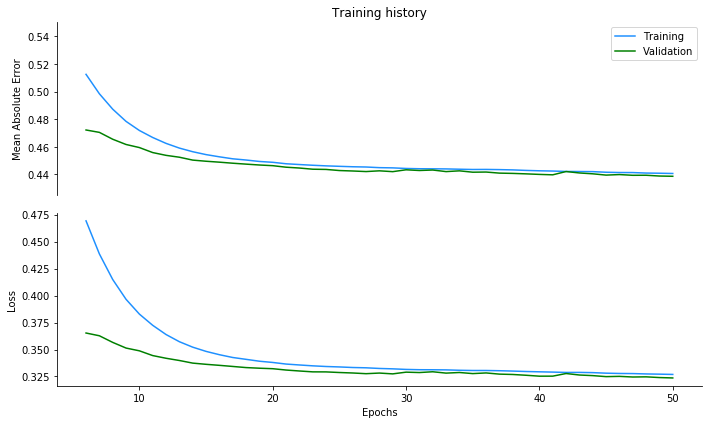

In [16]:
# plotting functions modified from github.com/whyboris and 'Deep Learning with Python' by François Chollet

def smooth_curve(points, factor=0.75):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

def set_plot_history_data(ax, history, which_graph):

    if which_graph == 'mae':
        train = smooth_curve(history.history['mean_absolute_error'])
        valid = smooth_curve(history.history['val_mean_absolute_error'])

    if which_graph == 'loss':
        train = smooth_curve(history.history['loss'])
        valid = smooth_curve(history.history['val_loss'])

    epochs = range(1, len(train) + 1)

    # when graphing loss the first few epochs may skew the (loss) graph
    trim = 5 # remove first 5 epochs
    

    ax.plot(epochs[trim:], train[trim:], 'dodgerblue', label=('Training'))
    ax.plot(epochs[trim:], valid[trim:], 'g', label=('Validation'))

def get_max_validation_accuracy(history):
    validation = smooth_curve(history.history['val_mean_absolute_error'])
    ymax = max(validation)
    return 'Max validation accuracy ≈ ' + str(round(ymax, 3)*100) + '%'

def plot_history(history):    

    fig, (ax1, ax2) = plt.subplots(nrows=2,
                                   ncols=1,
                                   figsize=(10, 6),
                                   sharex=True)

    set_plot_history_data(ax1, history, 'mae')
    set_plot_history_data(ax2, history, 'loss')

    # mae graph
    ax1.set_ylabel('Mean Absolute Error')
    ax1.set_ylim(bottom=0.425, top=0.55)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.xaxis.set_ticks_position('none')
    ax1.spines['bottom'].set_visible(False)


    # Loss graph
    ax2.set_ylabel('Loss')
    ax2.plot(legend=False)
    ax2.set_xlabel('Epochs')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax1.legend(loc="upper right")
    ax1.set_title('Training history')

    plt.tight_layout()

# show training history using above functions
plot_history(history)

Evaluate model and show the results. This model predicts the test data scores with an error of 0.44 stars.

In [17]:
results = model.evaluate(xTest, yTest)
print('')
print('Model evaluation using test data')
print('')
print('Loss: {0:.4f}'.format(results[0]))
print(' MAE: {0:.4f}'.format(results[1]))

16785/16785 [==============================] - 0s 17us/step

Model evaluation using test data

Loss: 0.3238
 MAE: 0.4386


### Create deep learning model using route comments

Create a new dataframe containing route comments and scores, and drop rows with comment string length shorter than *min_chars* .

In [0]:
df_text = df[['commentList','scoreStars']].copy().astype(str)

# drop rows with comments shorter than min_chars characters
min_chars = 500
mask = df_text['commentList'].str.len() >= min_chars
df_text = df_text.loc[mask]

Perform text preprocessing.

In [19]:
import re
import nltk
from nltk.corpus import stopwords
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelBinarizer

# download nltk stopwords
nltk.download('stopwords')

# create regex strings to remove characters, symbols, and stopwords
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

# define 
def clean_text(text):
    """
        text: a string
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwords from text
    return text
  
df_text['commentList'] = df_text['commentList'].apply(clean_text)
df_text['commentList'] = df_text['commentList'].str.replace('\d+', '')

# tokenize words
from keras.preprocessing.text import Tokenizer

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 10000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 500
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df_text['commentList'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

# truncate and pad input sequences so they are all same length
X = tokenizer.texts_to_sequences(df_text['commentList'].values)
X_text = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

# do not preprocess ratings since model will use regression for continuous values
y = df_text['scoreStars']

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Found 61462 unique tokens.


Split the data into training, validation, and testing sets.

In [0]:
# split training data into train_partial and validation sets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer

# train test split feat, text, and label arrays
X_text_train, X_text_test, y_train, y_test = train_test_split(X_text, y, test_size=0.2, random_state=42)

# validation splits
X_text_train_partial, X_text_val, y_train_partial, y_val = train_test_split(X_text, y, test_size=0.2, random_state=42)

### Train the deep learning model

In [24]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import math
import os
import pprint
import matplotlib.pyplot as plt

from sklearn import metrics

def get_model():
  return keras.Sequential([
      keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_text_train.shape[1]),
      keras.layers.GRU(100, dropout=0.3, recurrent_dropout=0.3),
      keras.layers.Dense(10, activation='relu'),
      keras.layers.Dropout(0.3),
      keras.layers.Dense(1)
  ])

model = get_model()
model.compile(optimizer=tf.train.AdamOptimizer(.001),
             loss='mean_squared_error',
             metrics=['mean_absolute_error'])

# define an early stopping callback (may not be necessary since training is fast and converges)
useEarlyStopping = True
if useEarlyStopping:
  callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001)]
else:
  callbacks=None

# train the model
history = model.fit(X_text_train_partial, 
                    y_train_partial, 
                    validation_data=(X_text_val, y_val), 
                    batch_size=128, 
                    epochs=100, 
                    verbose=1,
                    callbacks=callbacks)

Train on 16250 samples, validate on 4063 samples
Epoch 1/100
16250/16250 [==============================] - 251s 15ms/sample - loss: 2.2731 - mean_absolute_error: 1.2067 - val_loss: 0.5943 - val_mean_absolute_error: 0.6303
Epoch 2/100
16250/16250 [==============================] - 254s 16ms/sample - loss: 1.1101 - mean_absolute_error: 0.8405 - val_loss: 0.5054 - val_mean_absolute_error: 0.5823
Epoch 3/100
16250/16250 [==============================] - 238s 15ms/sample - loss: 1.0148 - mean_absolute_error: 0.7974 - val_loss: 0.3566 - val_mean_absolute_error: 0.4821
Epoch 4/100
16250/16250 [==============================] - 240s 15ms/sample - loss: 0.9416 - mean_absolute_error: 0.7708 - val_loss: 0.4114 - val_mean_absolute_error: 0.5197
Epoch 5/100
16250/16250 [==============================] - 234s 14ms/sample - loss: 0.8692 - mean_absolute_error: 0.7361 - val_loss: 0.3635 - val_mean_absolute_error: 0.4833
Epoch 6/100
16250/16250 [==============================] - 234s 14ms/sample - los

### Plot the learning

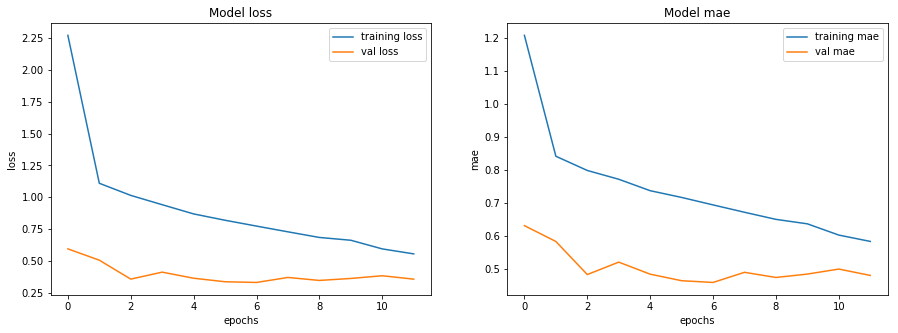

In [25]:
# plot training and validation loss and mae vs. epochs

# get training history as dictionary
history_dict = history.history

# set up values
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_mae = history_dict['mean_absolute_error']
val_mae = history_dict['val_mean_absolute_error']

# set up figure
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(15,5))

# loss plot
ax1.plot(train_loss, label='training loss')
ax1.plot(val_loss, label='val loss')
ax1.set_title('Model loss')
ax1.set(xlabel='epochs', ylabel='loss')
ax1.legend()

# accuracy plot
ax2.plot(train_mae, label='training mae')
ax2.plot(val_mae, label='val mae')
ax2.set_title('Model mae')
ax2.set(xlabel='epochs', ylabel='mae')
ax2.legend()

### Evaluate the model on test data

In [26]:
results = model.evaluate(X_text_test, y_test)
print('')
print('Model evaluation using test data')
print('')
print('Loss: {0:.4f}'.format(results[0]))
print(' MAE: {0:.4f}'.format(results[1]))

4063/4063 [==============================] - 15s 4ms/sample - loss: 0.3563 - mean_absolute_error: 0.4795

Model evaluation using test data

Loss: 0.3563
 MAE: 0.4795
